In [1]:
# Copyright (c) 2020 a1kageyama
# Released under the MIT license
# https://github.com/a1kageyama/AI_Sushi_Counter

import numpy as np
from PIL import Image
import os, glob, random
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import CnnModel
import keras

In [2]:
outFile = "SystemData/Model/SushiPhotos.npz"
maxPhoto = 200
xPath = []
yLabel = []

# Keep the size of the training model under the maximum GitHub file size of 100MB.
# To achieve this, the image was reduced from 64 pixels to 60 pixels.
photoSize = 60

In [3]:
# All Images to Numpy Format
def saveImages():

    # Load the Image of a Folder
    readImages("./SystemData/PhotoData/Bonito", 0)
    readImages("./SystemData/PhotoData/CaliforniaRoll", 1)
    readImages("./SystemData/PhotoData/CongerEel", 2)
    readImages("./SystemData/PhotoData/FattyTuna", 3)
    readImages("./SystemData/PhotoData/InariSushi", 4)
    readImages("./SystemData/PhotoData/LeanTuna", 5)
    readImages("./SystemData/PhotoData/Mackerel", 6)
    readImages("./SystemData/PhotoData/Salmon", 7)
    readImages("./SystemData/PhotoData/SalmonRoe", 8)
    readImages("./SystemData/PhotoData/Scallop", 9)
    readImages("./SystemData/PhotoData/SeaUrchin", 10)
    readImages("./SystemData/PhotoData/Shrimp", 11)
    readImages("./SystemData/PhotoData/SushiBurrito", 12)
    readImages("./SystemData/PhotoData/Tamago", 13)
    readImages("./SystemData/PhotoData/TunaRoll", 14)

    # Save to File
    np.savez(outFile, x=xPath, y=yLabel)
    print("Save completed : " + outFile, len(xPath))

In [4]:
# Labeling Images in a Path
def readImages(path, label):

    files = glob.glob(path + "/*.jpg")
    random.shuffle(files)
    num = 0
    
    for f in files:
        if num >= maxPhoto: break
        num += 1
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((photoSize, photoSize))
        img = np.asarray(img)
        xPath.append(img)
        yLabel.append(label)

In [5]:
# Save the Image Data to Numpy Format
saveImages()

Save completed : SystemData/Model/SushiPhotos.npz 3000


In [6]:
# Specify Input and Output
imgRow = 60
imgCol = 60
imgColor = 3
inShape = (imgRow, imgCol, imgColor)
nbClass = 15

# Loading Photo Data
photos = np.load("SystemData/Model/SushiPhotos.npz")
xPhotos = photos["x"]
yPhotos = photos["y"]

In [7]:
# Convert the Read Data into a Three-Dimensional Array
xPhotos = xPhotos.reshape(-1, imgRow, imgCol, imgColor)
xPhotos = xPhotos.astype("float32") / 255

# Fix Label Data to One-Hot Vectors
yPhotos = keras.utils.to_categorical(yPhotos.astype("int32"), nbClass)

# Separate for Training and Testing
xTrain, xTest, yTrain, yTest = train_test_split(xPhotos, yPhotos, train_size=0.8)

In [8]:
# Data Augmentation
xNew = []
yNew = []
for i, xi in enumerate(xTrain):
    yi = yTrain[i]
    for ang in range(-30, 30, 20):

        # Rotation
        center = (30, 30)
        mtx = cv2.getRotationMatrix2D(center, ang, 1.0)
        xi2 = cv2.warpAffine(xi, mtx, (60, 60))
        xNew.append(xi2)
        yNew.append(yi)

        # Horizontal flipping
        xi3 = cv2.flip(xi2, 1)
        xNew.append(xi3)
        yNew.append(yi)

In [9]:
# Replacing Data Augmentation Images for Training
print("Before Data Augmentation : ", len(yTrain))
xTrain = np.array(xNew)
yTrain = np.array(yNew)
print("After  Data Augmentation : ", len(yTrain))

Before Data Augmentation :  2400
After  Data Augmentation :  14400


In [10]:
# Getting the CNN model
model = CnnModel.getModel(inShape, nbClass)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv (Conv2D)         (None, 58, 58, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 58, 58, 64)        256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 29, 29, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 64)        0         
_________________________________________________________________
block2_conv (Conv2D)         (None, 27, 27, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 128)       512       
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 13, 13, 128)       0

In [11]:
# Perform Learning
hist = model.fit(xTrain, yTrain,
          batch_size=8,
          epochs=20,
          verbose=1,
          validation_data=(xTest, yTest))

Epoch 1/20
1800/1800 [==============================] - 20s 11ms/step - loss: 1.7610 - accuracy: 0.4583 - val_loss: 1.5213 - val_accuracy: 0.5367
Epoch 2/20
1800/1800 [==============================] - 16s 9ms/step - loss: 1.2043 - accuracy: 0.6042 - val_loss: 1.4670 - val_accuracy: 0.5617
Epoch 3/20
1800/1800 [==============================] - 16s 9ms/step - loss: 0.9576 - accuracy: 0.6890 - val_loss: 1.0087 - val_accuracy: 0.6867
Epoch 4/20
1800/1800 [==============================] - 16s 9ms/step - loss: 0.8019 - accuracy: 0.7394 - val_loss: 1.0773 - val_accuracy: 0.7100
Epoch 5/20
1800/1800 [==============================] - 17s 9ms/step - loss: 0.6756 - accuracy: 0.7782 - val_loss: 1.0279 - val_accuracy: 0.7183
Epoch 6/20
1800/1800 [==============================] - 15s 8ms/step - loss: 0.6016 - accuracy: 0.8067 - val_loss: 0.9573 - val_accuracy: 0.7317
Epoch 7/20
1800/1800 [==============================] - 16s 9ms/step - loss: 0.5300 - accuracy: 0.8306 - val_loss: 1.1363 - val_a

In [12]:
# Evaluating Model
score = model.evaluate(xTest, yTest, verbose=1)
print("Accuracy =", score[1], "Loss =", score[0])

19/19 [==============================] - 6s 297ms/step - loss: 1.1815 - accuracy: 0.7900
Accuracy = 0.7900000214576721 Loss = 1.1814591884613037


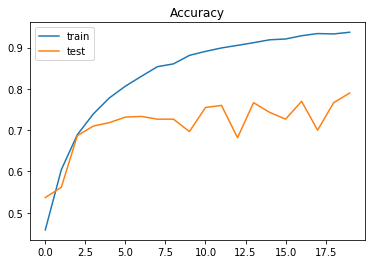

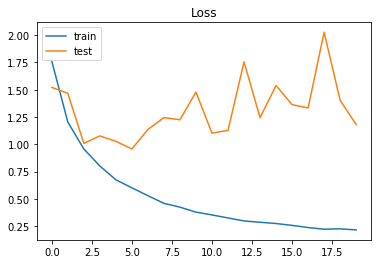

In [13]:
# Plotting the Accuracy Trends
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Accuracy")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Plotting the Loss Trends
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [14]:
# Save the trained models
model.save_weights("./SystemData/Model/SushiModel.hdf5")